In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [137]:
class GraphNet:
    # Make an empty graph on n nodes with linear activation
    def __init__(self, n):
        self.size = n
        self.adj = np.zeros((n, n))
        self.weights = np.zeros((n, n))
        self.act = np.asarray(['linear' for i in range(self.size)])
        self.input_nodes = np.asarray([0]) # Default
        self.output_nodes = np.asarray([n-1]) # Default
        #self.tempstates = [np.zeros(self.size)] # Needs to be dynamically resized
        #self.states = [np.zeros(self.size)] # Needs to be dynamically resized
        #self.mode = 'overwrite'
        #self.time = 0
    
    # Sets the mode for the step method
    # Options: overwrite, add
    def mode(self, m):
        self.mode = m
    
    # Connect an edge from node i to node j
    def connect(self, i, j):
        self.adj[i,j] = 1
    
    # Connect a list of nodes in a sequential loop
    def connect_loop(self, v):
        for i in range(len(v)):
            self.adj[v[i], v[(i+1)%len(v)]] = 1
    
    # Connect in a clique, other than self-connections
    def connect_complete(self, v):
        for i in range(len(v)):
            for j in range(len(v)):
                if i == j:
                    continue
                self.adj[v[i], v[j]] = 1
    
    # Change activation on node i
    # Options: linear, relu, sigmoid/logistic, tanh
    def activation(self, i, f):
        self.act[i] = f
    
    # Change activations on a list of nodes
    def activations(self, v, f):
        for i in range(len(v)):
            self.act[v[i]] = f
    
    # Get the list of node indices for inputs to node i
    def inputs(self, i):
        return np.nonzero(self.adj[:,i])[0] # Returns a tuple even on a 1D array
    
    # Get the list of node indices for outputs from node i
    def outputs(self, i):
        return np.nonzero(self.adj[i,:])[0] # Returns a tuple even on a 1D array
    
    # Reset weights
    def reset_weights(self):
        self.weights = np.copy(self.adj)
        self.reset_state() # No reason to save the state if the weights were reset.
    
    # Initialize random edge weights, assuming edge weights are all 0 or 1
    def init_random(self):
        self.weights = np.random.normal(size=(self.size, self.size)) * self.adj
    
    # Normalize rows to satisfy Markov state transition rules
    def init_markov(self):
        self.weights = np.random.random((self.size, self.size)) * self.adj
        rowsums = np.sum(self.weights, axis=1, keepdims=True)
        rowsums[rowsums == 0] = 1 # Prevent division by zero when normalizing the columns
        self.weights = self.weights/rowsums
    
    def init_uniform(self):
        self.weights = np.copy(self.adj)
    
    # Make the vector of indices be the input nodes
    def define_input(self, v):
        self.input_nodes = v
    
    # Make the vector of indices be the output nodes
    def define_output(self, v):
        self.output_nodes = v
        
    # numpy activation functions
    # could be static, but meh
    def relu(self, x):
        return x * (x > 0)
    
    def sigmoid(self, x):
        return 1.0/(1.0+np.exp(-x))
    
    def tanh(self, x):
        return (np.exp(2*x) - 1)/(np.exp(2*x) + 1)
    
    # TODO: Redesign the steps so that multiple steps are done and the array of states is optionally returned,
    # so that it doesn't modify the state variable every time it runs the network.
    # This will allow for greater thread concurrency.
    
    # Combine all the old step functions
    # Length of the output is n+1 because of the initial state of 0
    def step(self, input_vals, n, weights = None):
        temp_weights = self.weights
        if weights is not None:
            temp_weights = weights
        x_states = [np.zeros(self.size)]
        z_states = [np.zeros(self.size)]
        input_vals = np.array(input_vals)
        
        for t in range(n):
            input_state = np.zeros(self.size)
            if input_vals.ndim == 1 and t == 0:
                # Single value input
                input_state[self.input_nodes] = input_vals
            elif input_vals.ndim == 2:
                # Sequence input
                if t < input_vals.shape[0]:
                    input_state[self.input_nodes] = input_vals[t]

            # Bias neurons need to be activated before the step
            input_state[self.act == 'bias'] = 1
            
            # This feels like it could be really bad.
            # This makes it *absolutely mandatory* that there are no connections feeding into the input neurons.
            z_states[-1] += input_state

            # Activation functions are not run on the input nodes prior to entering the network.
            # Preprocessing should take care of that anyway.
            # So the inputs are considered the z state for their respective neurons.
            # The x states on those neurons are all zero, but it doesn't really matter, 
            # since they can't come up in the backprop anyway.
            
            # Weighted sum of inputs (always adding the input state in)
            new_x_state = z_states[-1] @ temp_weights
            
            # Apply activation functions to update the state (temporary states are stored for backprop)
            new_z_state = np.copy(new_x_state)

            # Applying activation functions in separate sets for each neuron that has a given one
            new_z_state[self.act == 'relu'] = self.relu(new_z_state[self.act == 'relu'])
            # This is kind of dumb, but initializing with 'linear' means numpy will cut off the string 'sigmoid'
            new_z_state[self.act == 'sigma'] = self.sigmoid(new_z_state[self.act == 'sigma']) 
            new_z_state[self.act == 'tanh'] = self.tanh(new_z_state[self.act == 'tanh'])
            
            x_states.append(new_x_state)
            z_states.append(new_z_state)
        return np.array(x_states), np.array(z_states)
    
    # Simple function to get cleaner output
    def get_output(self, input_vals, n_steps, seq_len=1):
        x, z = self.step(input_vals, n_steps)
        return z[-seq_len:][:, self.output_nodes]
    
    # Old code for reference
    """
    
    # Reset state
    def reset_state(self):
        self.states = [np.zeros(self.size)]
        self.tempstates = [np.zeros(self.size)]
    
    # Runs one time step of the network, with the given input values, and returns the current output values
    def step(self, input_vals):
        self.time += 1
        # tempstate = [self.states[-1][i] for i in range(self.size)]
        # Edit the inputs of the last state. This will make things consistent, so each step is a single state
        if self.mode == 'overwrite':
            for i in range(len(self.input_nodes)):
                self.states[-1][self.input_nodes] = input_vals
        if self.mode == 'add':
            for i in range(len(self.input_nodes)):
                self.states[-1][self.input_nodes] += input_vals
        
        # Bias neurons need to be activated before the step
        self.states[-1][self.act == 'bias'] = 1
        
        # Weighted sum of inputs
        tempstate = self.states[-1] @ self.weights
        
        # Apply activation functions to update the state (temporary states are stored for backprop)
        state = np.copy(tempstate)
        
        # Applying activation functions in separate sets for each neuron that has a given one
        state[self.act == 'relu'] = self.relu(state[self.act == 'relu'])
        # This is kind of dumb, but initializing with 'linear' means numpy will cut off the string 'sigmoid'
        state[self.act == 'sigma'] = self.sigmoid(state[self.act == 'sigma']) 
        state[self.act == 'tanh'] = self.tanh(state[self.act == 'tanh'])
        
        output_vals = state[self.output_nodes]
        self.tempstates.append(tempstate)
        self.states.append(state)
        return output_vals
    
    # Runs several time steps of the network, with the given vector of input value vectors at each time step, 
    # and returns a vector of output values
    def steps(self, input_vals_v, n=1):
        output_vals_v = np.zeros((n, len(self.input_nodes)))
        empty_input = np.zeros(len(self.input_nodes))
        for t in range(max(n, len(input_vals_v))):
            input_vals = empty_input
            if t < len(input_vals_v):
                input_vals = input_vals_v[t]
            output_vals_v[t] = self.step(input_vals)
        return output_vals_v
    
    # Run n steps on a input only at initial step
    def stepn(self, input_vals_0, n=1, reset=True):
        if reset:
            self.reset_state()
        output_vals_v = np.zeros((n, len(self.output_nodes)))
        empty_input = np.zeros(len(self.input_nodes))
        for t in range(n):
            input_vals = empty_input
            if t == 0:
                input_vals = input_vals_0
            output_vals_v[t] = self.step(input_vals)
        return output_vals_v
    
    # Run as many steps as necessary until you get a nonzero output 
    # (Obviously not a great thing to run if you have any sigmoid activations)
    def stepv(self, input_vals_0, reset=True, max_step=100, verbose=True):
        if reset:
            self.reset_state()
        output_vals = np.zeros(len(self.output_nodes))
        empty_input = np.zeros(len(self.input_nodes))
        t = 0
        while t < max_step and np.count_nonzero(output_vals) == 0:
            input_vals = empty_input
            if t == 0:
                input_vals = input_vals_0
            output_vals = self.step(input_vals)
            t += 1
        if t == max_step:
            print("Max step reached!")
        if verbose:
            print(t)
        return output_vals
    """
    
    # Combine all the old error functions (for MSE)
    # Error calculation must be separate for backprop, because we don't want to run through the steps multiple times.
    # So this is just for model evaluation (for a particular training example)
    def get_loss(self, input_sequence, label_sequence, delay, weights=None):
        using_weights = False
        temp_weights = None
        if weights is not None:
            using_weights = True
            temp_weights = weights
        seq_len = 1
        steps = delay
        label_sequence = np.array(label_sequence)
        if label_sequence.ndim == 2:
            seq_len = label_sequence.shape[0]
            steps = delay + seq_len - 1
        x_states, z_states = self.step(input_sequence, steps, temp_weights if using_weights else None)
        outputs = z_states[-seq_len:, self.output_nodes]
        error = np.sum(np.subtract(outputs, label_sequence)**2)
        return 0.5*error # 1/2 sum (z-y)^2
    
    # Old code for reference
    """
    # Waits until the first nonzero output value and uses that as the real output
    def error_first(self, train_vals, label_vals, max_step=100):
        self.reset_state()
        output_vals = np.zeros(len(self.output_nodes))
        empty_input = np.zeros(len(self.input_nodes))
        t = 0
        while t < max_step and np.count_nonzero(output_vals) == 0:
            input_vals = empty_input
            if t == 0:
                input_vals = train_vals
            output_vals = self.step(input_vals)
            t += 1
        if t == max_step:
            print("Max step reached!")
        err_v = np.subtract(output_vals, label_vals)
        return err_v
    
    # Waits a fixed delay
    def error_delay(self, train_vals, label_vals, delay, reset=True, max_step=100):
        if reset:
            self.reset_state()
        output_vals = np.zeros(len(self.output_nodes))
        empty_input = np.zeros(len(self.input_nodes))
        t = 0
        while t < delay:
            input_vals = empty_input
            if t == 0:
                input_vals = train_vals
            output_vals = self.step(input_vals)
            t += 1
        if t == max_step:
            print("Max step reached!")
        err_v = np.subtract(output_vals, label_vals)
        return err_v
    
    # Delay is until the label sequence starts.
    # Training sequence can be any length, but should be a 2D array
    def error_sequence(self, train_seq, label_seq, delay=1, reset=True):
        if reset:
            self.reset_state()
        output_seq = np.zeros((len(label_seq), len(self.output_nodes)))
        empty_input = np.zeros(len(self.input_nodes))
        t = 0
        while t < delay+len(label_seq)-1:
            input_vals = empty_input
            if t < len(train_seq):
                input_vals = train_seq[t]
            if t < delay-1:
                self.step(input_vals)
            else:
                output_seq[t-delay+1] = self.step(input_vals)
            t += 1
        #print(output_seq)
        #print(label_seq)
        err_v = np.subtract(output_seq, label_seq)
        #print('Err_v: '+str(err_v))
        return err_v
    
    # Mean square error of training batch. train_x and train_y are batches of training data
    # If delay = 0, first nonzero output will be used, otherwise there will be a fixed delay before the output is sampled
    def mse_batch(self, train_x, train_y, delay=0, reset=True, max_step=100):
        data_type = 'fixed'
        if np.asarray(train_x).ndim == 3:
            data_type = 'sequence'
        mse = 0
        # Should be able to parallelize over training examples
        # However, I should use a different version of the stepping for this so it doesn't modify the state variable
        for k in range(len(train_x)):
            if data_type == 'fixed':
                if delay == 0:
                    mse += np.sum(self.error_first(train_x[k], train_y[k], max_step)**2)
                else:
                    mse += np.sum(self.error_delay(train_x[k], train_y[k], delay, reset, max_step)**2)
            elif data_type == 'sequence':
                val = self.error_sequence(train_x[k], train_y[k], delay, reset)
                #print('Err: '+str(val))
                mse += sum(val**2)
        mse /= 2*len(train_x) # Factor of 1/2 for the coefficient of 2 on the derivative to cancel, as usual...
        return mse
        """
    
    def derivative_relu(self, x):
        return 1 * (x > 0)
    
    # Note that this uses Z instead of X
    def derivative_sigmoid(self, z):
        return z * (1 - z)
    
    def derivative_tanh(self, x):
        return 4/(np.exp(x) + np.exp(-x))**2
    
    def derivative_activation(self, X, Z, t):
        V = np.ones(self.size)
        #V[self.act == 'linear'] = 1
        V[self.act == 'bias'] = 0
        V[self.act == 'relu'] = self.derivative_relu(X[t][self.act == 'relu'])
        V[self.act == 'sigma'] = self.derivative_sigmoid(Z[t][self.act == 'sigma']) 
        V[self.act == 'tanh'] = self.derivative_tanh(X[t][self.act == 'tanh'])
        return V
    
    def backprop(self, input_sequence, label_sequence, delay, debug=False):
        # Calculate the required number of steps using the delay and the length of the label sequence
        # If the label sequence is not two-dimensional, then it's just a single output value
        seq_len = 1
        steps = delay
        label_sequence = np.array(label_sequence)
        if label_sequence.ndim == 2:
            seq_len = label_sequence.shape[0]
            steps = delay + seq_len - 1
        # Outputs at each time step before and after applying activation functions
        X, Z = self.step(input_sequence, steps)
        # Output labels
        Y = np.zeros((seq_len, self.size))
        Y[:, self.output_nodes] = label_sequence
        # X and Z are steps x size
        # Y is seq_len x size
        # Square error
        E = np.sum((Z[-seq_len:, self.output_nodes] - label_sequence)**2)
        # Masking values
        M = np.zeros(self.size)
        M[self.output_nodes] = 1
        # Alias to make things easier to keep track of...
        W = self.weights
        #if debug:
        #    print('W', '\n'+str(W))
        # Going to be dividing by weights, but throw them out entirely if they are zero
        # Turns out the bug was that the values are uninitialized when the where argument is used.
        # Easy enough to fix. I still think it's weird that the result depended on whether the array was printed or not.
        W_recip = np.zeros_like(W)
        np.reciprocal(W, out=W_recip, where=(W != 0))
        if debug:
            print('W recip', '\n'+str(W_recip))
        # Time delay
        T = delay
        # Column of 1s to perform broadcasting before a dot product
        C = np.ones((self.size, 1))
        # The gradient for each weight in the adjacency matrix
        D = np.zeros((self.size, self.size))
        for S in range(0, seq_len):
            # Path concatenation matrix: Weights times activations (applied to X, at various time steps)
            B_final = W * self.derivative_activation(X, Z, T+S)
            if debug:
                print('B at', T+S, '\n'+str(B_final))
            # First order term is relatively simple
            first_order = Z[(T+S-1):(T+S)].T * W_recip * (Z[(T+S):(T+S+1)] - Y[S:(S+1)]) * M * B_final
            if debug:
                print('first order', '\n'+str(first_order))
            D += first_order
            B_prod = B_final.copy()
            for N in range(1, T+S):
                # Pre-multiply by the previous time's path concatenation matrix
                B_prev = W * self.derivative_activation(X, Z, T+S-N)
                if debug:
                    print('B at', T+S-N, '\n'+str(B_prev))
                # Calculate the next order, lining up the matrix product to get a sum over outputs
                next_order = Z[(T+S-N-1):(T+S-N)].T * W_recip * B_prev * ((C @ (Z[(T+S):(T+S+1)] - Y[S:(S+1)]) * M) @ B_prod.T)
                if debug:
                    print('next order', '\n'+str(next_order))
                D += next_order
                B_prod = B_prev @ B_prod
                if debug:
                    print('B_prod', '\n'+str(B_prod))
        # This gradient is calculated for one training example over enough time steps to reach time zero
        if debug:
            print('D', '\n'+str(D))
        return D, E
    
    # Example to make sure this makes sense
    # T = 1, seq_len = 1
    # S = 0, B_1 first
    # Z[0:1].T / W * (Z[1:2] - Y[0:1]) * M * B_1
    # N loop doesn't activate
    #
    # T = 2, seq_len = 1
    # S = 0, B_2 first
    # Z[1:2].T / W * (Z[2:3] - Y[0:1]) * M * B_2
    # Z[0:1].T / W * (C @ ((Z[2:3] - Y[0:1]) * M) @ (B_1 @ B2).T)
    
    # Old code for reference
    """
    # Numpifying this seems difficult, with 4 nested for loops...
    # I'm also not entirely sure this is correct. Models trained with it seem to reach the local minimum correctly, though.
    def backprop(self, train_vals, label_vals, delay=1, verbose=False):
        # Initialize with zero matrix of derivatives for each weight
        dw = np.zeros((self.size, self.size))
        # Calculate error function
        # E = 1/2 (observed - expected)**2
        err_v = [[0 for i in range(len(self.output_nodes))]] #Initialize to empty array for each output node
        if len(np.asarray(label_vals).shape) == 1:
            err_v = [self.error_delay(train_vals, label_vals, delay)] # Row vector, one time step
        if len(np.asarray(label_vals).shape) == 2:
            err_v = self.error_sequence(train_vals, label_vals, delay=delay) # 2D, rows are time steps
        # Look at each time step
        for dt in range(len(err_v)):
            nodes_i = [self.output_nodes[i] for i in range(len(self.output_nodes))]
            nodes_d = [err_v[len(err_v)-1-dt][i] for i in range(len(self.output_nodes))]
            newnodes_i = []
            newnodes_d = []
            # dE/dw = (observed - expected) * d(observed)/dw
            for k in range(1, len(self.states)-dt): # Or max step size, maybe? 
                #print('Paths:', len(nodes_i), "\t dt:", dt, "\t k:", k)
                for i in range(len(nodes_i)):
                    # node value = activation( weighted sum of input values )
                    # d node value / dw = activation'( weighted sum of input values ) * d (weighted sum of input values) / dw
                    node_val = self.states[len(self.states)-k-dt][nodes_i[i]]
                    node_sum = self.tempstates[len(self.states)-k-dt][nodes_i[i]]
                    act_deriv = 1
                    #if self.act[nodes_i[i]] == 'linear':
                    #    do nothing
                    if self.act[nodes_i[i]] == 'relu' and node_sum < 0:
                        act_deriv = 0
                    if self.act[nodes_i[i]] == 'sigma':
                        act_deriv = node_val * (1 - node_val)
                    if self.act[nodes_i[i]] == 'tanh':
                        act_deriv = 4.0/(math.exp(node_sum)+math.exp(-node_sum))**2
                    #print("nodes_i[i]", nodes_i[i])
                    in_nodes_i = self.inputs(nodes_i[i])
                    #print("in_nodes_i", in_nodes_i)
                    for j in range(len(in_nodes_i)):
                        # Self-weights are covered just fine when nodes_i[i] = in_nodes_i[j]
                        in_node_val = self.states[len(self.states)-(k+1)-dt][in_nodes_i[j]]
                        # d (weighted sum of input values) / dw = input value [...for w in these weights]
                        dweight = nodes_d[i] * act_deriv * in_node_val
                        # Add this to the total derivative with respect to this weight
                        dw[nodes_i[i], in_nodes_i[j]] += dweight
                        if verbose:
                            print(dw)
                        # nodes_d stores the buildup of chained derivatives
                        weight = self.weights[nodes_i[i], in_nodes_i[j]]
                        # d (weighted sum of input values) / dw = ... * weight * d node value / dw
                        #print(in_nodes_i, in_nodes_i[j], newnodes_i)
                        if in_nodes_i[j] in newnodes_i:
                            index = newnodes_i.index(in_nodes_i[j])
                            newnodes_d[index] += nodes_d[i] * act_deriv * weight
                        else:
                            #print(newnodes_i, in_nodes_i[j])
                            newnodes_i.append(in_nodes_i[j])
                            newnodes_d.append( nodes_d[i] * act_deriv * weight )
                nodes_i = newnodes_i
                nodes_d = newnodes_d
                newnodes_i = []
                newnodes_d = []
        return dw
    """
    
    # Manually check to see if the gradients line up with what the backprop function gives
    def gradient_check(self, input_sequence, label_sequence, delay, epsilon):
        backprop_gradient = self.backprop(input_sequence, label_sequence, delay)[0]
        manual_gradient = np.zeros((self.size, self.size))
        base_err = self.get_loss(input_sequence, label_sequence, delay)
        for i in range(self.size):
            for j in range(self.size):
                if self.weights[i, j] == 0:
                    continue
                dw = np.zeros((self.size, self.size))
                dw[i, j] = epsilon
                grad = (self.get_loss(input_sequence, label_sequence, delay, self.weights + dw) - base_err)/epsilon
                manual_gradient[i, j] = grad
        print('Backprop-calculated gradient:')
        print(backprop_gradient)
        print('Manually-calculated gradient:')
        print(manual_gradient)
        print('Difference:')
        print(backprop_gradient-manual_gradient)
    
    # Uses the whole dataset as the batches
    def train(self, train_x, train_y, delay, epochs, learning_rate):
        errors = []
        for ep in range(epochs):
            avg_D = np.zeros((self.size, self.size))
            avg_E = 0
            for k in range(len(train_x)):
                D, E = self.backprop(train_x[k], train_y[k], delay)
                avg_D += D
                avg_E += E
            avg_D /= len(train_x)
            avg_E /= len(train_x)
            #print(avg_D)
            #print(avg_E)
            self.weights += - learning_rate * avg_D
            # Evaluate error to see how we're doing.
            errors.append(avg_E)
        print(self.weights)
        return errors

In [54]:
test = GraphNet(3)
test.connect(0,1)
test.connect(1,2)
test.activations([1,2], 'sigma')
test.init_markov()
test.weights

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

In [42]:
test.weights *= 0.9

In [31]:
x, z = test.step([1], 2)

In [32]:
print(x)
print(z)

[[0.         0.         0.        ]
 [0.         0.9        0.        ]
 [0.         0.         0.63985455]]
[[1.         0.         0.        ]
 [0.         0.7109495  0.5       ]
 [0.         0.5        0.65472058]]


In [33]:
test.backprop([[1]], [[1]], 2, debug=True)

W recip 
[[0.         1.11111111 0.        ]
 [0.         0.         1.11111111]
 [0.         0.         0.        ]]
B at 2 
[[0.         0.225      0.        ]
 [0.         0.         0.20345539]
 [0.         0.         0.        ]]
first order 
[[ 0.          0.         -0.        ]
 [ 0.          0.         -0.05549274]
 [ 0.          0.         -0.        ]]
B at 1 
[[0.         0.18495028 0.        ]
 [0.         0.         0.225     ]
 [0.         0.         0.        ]]
next order 
[[ 0.         -0.01443618  0.        ]
 [ 0.         -0.          0.        ]
 [ 0.         -0.          0.        ]]
B_prod 
[[0.         0.         0.03762913]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
D 
[[ 0.         -0.01443618  0.        ]
 [ 0.          0.         -0.05549274]
 [ 0.          0.          0.        ]]


(array([[ 0.        , -0.01443618,  0.        ],
        [ 0.        ,  0.        , -0.05549274],
        [ 0.        ,  0.        ,  0.        ]]), 0.11921787702676306)

In [67]:
test.gradient_check([[1]], [[1]], 2, epsilon=0.000001)

Backprop-calculated gradient:
[[ 0.         -0.01401536  0.        ]
 [ 0.          0.         -0.05211305]
 [ 0.          0.          0.        ]]
Manually-calculated gradient:
[[ 0.         -0.01401535  0.        ]
 [ 0.          0.         -0.05211303]
 [ 0.          0.          0.        ]]
Difference:
[[ 0.00000000e+00 -4.62332528e-09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.94988543e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [68]:
linear = GraphNet(3)
linear.connect(0,2)
linear.connect(1,2)
linear.activation(1, 'bias')
linear.define_input([0])
linear.define_output([2])
linear.init_markov() # Makes it really be slope and intercept 1 to begin

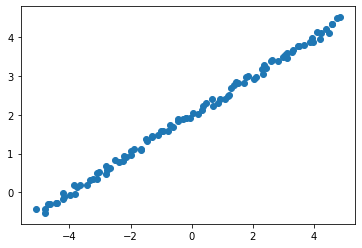

In [69]:
scatter = 0.1
slope = 0.5
intercept = 2
# Uniformly scattered points off a line
train_lin_x = [[-5 + 0.1*i + scatter*(-1+2*random.random())] for i in range(100)]
train_lin_y = [[intercept + slope*(-5+0.1*i) + scatter*(-1+2*random.random())] for i in range(100)]
plt.scatter(train_lin_x, train_lin_y)

In [70]:
linear.step([0], 1)

(array([[0., 0., 0.],
        [0., 0., 1.]]), array([[0., 1., 0.],
        [0., 0., 1.]]))

In [71]:
# Estimated slope and intercept are present in the weights of the trained network
errs = linear.train(train_lin_x, train_lin_y, delay=1, epochs=100, learning_rate=0.1)

[[0.         0.         0.50088902]
 [0.         0.         1.9985163 ]
 [0.         0.         0.        ]]


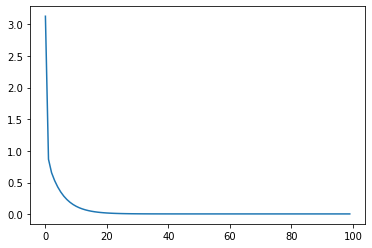

In [72]:
# Seems to work decently well
plt.plot(errs)

In [73]:
linear.gradient_check(train_lin_x[0], train_lin_y[0], delay=1, epsilon=0.000001)

Backprop-calculated gradient:
[[ 0.          0.          0.61411253]
 [ 0.          0.         -0.12059935]
 [ 0.          0.          0.        ]]
Manually-calculated gradient:
[[ 0.          0.          0.6141255 ]
 [ 0.          0.         -0.12059885]
 [ 0.          0.          0.        ]]
Difference:
[[ 0.00000000e+00  0.00000000e+00 -1.29650873e-05]
 [ 0.00000000e+00  0.00000000e+00 -5.00009668e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [74]:
# Testing a regular NN as a graph
xor_net = GraphNet(6)
xor_net.define_input([0,1])
xor_net.connect(0,3)
xor_net.connect(0,4)
xor_net.connect(1,3)
xor_net.connect(1,4)
xor_net.connect(2,3)
xor_net.connect(2,4)
xor_net.connect(2,5)
xor_net.connect(3,5)
xor_net.connect(4,5)
xor_net.activation(2, 'bias')
xor_net.activations([3,4,5], 'sigma')
xor_net.init_random()

In [75]:
train_x = [[0,0], [0,1], [1,0], [1,1]]
train_y = [[0], [1], [1], [0]]
errs_xor = xor_net.train(train_x, train_y, delay=2, epochs=5000, learning_rate=0.5)

[[-0.          0.          0.          5.22530668  4.8404654   0.        ]
 [-0.         -0.         -0.         -5.25229404 -4.59368784 -0.        ]
 [-0.         -0.         -0.         -2.96056489  2.27544543  3.13892944]
 [ 0.          0.         -0.          0.         -0.          7.13463366]
 [ 0.          0.          0.         -0.          0.         -6.81103931]
 [ 0.          0.          0.          0.          0.         -0.        ]]


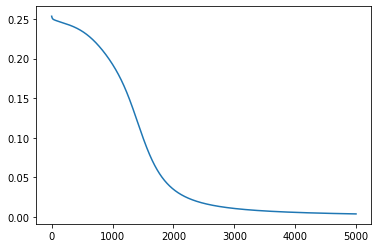

In [76]:
plt.plot(errs_xor)

In [77]:
# This is pretty much unreadable lol
print(xor_net.step([0,0], 2))
print(xor_net.step([0,1], 2))
print(xor_net.step([1,0], 2))
print(xor_net.step([1,1], 2))

(array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , -2.96056489,  2.27544543,
         3.13892944],
       [ 0.        ,  0.        ,  0.        , -2.96056489,  2.27544543,
        -2.68617093]]), array([[0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , 0.04923955, 0.90682292,
        0.95847029],
       [0.        , 0.        , 0.        , 0.04923955, 0.90682292,
        0.06379433]]))
(array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , -8.21285894, -2.31824241,
         3.13892944],
       [ 0.        ,  0.        ,  0.        , -2.98755226,  2.52222298,
         2.53043521]]), array([[0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.

In [79]:
xor_net.gradient_check(train_x, train_y, delay=2, epsilon=0.000001)

Backprop-calculated gradient:
[[ 0.          0.          0.         -0.00092767 -0.00137299  0.        ]
 [ 0.          0.          0.          0.00095742  0.00140962  0.        ]
 [ 0.          0.          0.          0.00033519 -0.00076588 -0.00137699]
 [ 0.          0.          0.          0.          0.         -0.00249415]
 [ 0.          0.          0.          0.          0.          0.00263667]
 [ 0.          0.          0.          0.          0.          0.        ]]
Manually-calculated gradient:
[[ 0.          0.          0.         -0.00092767 -0.00137299  0.        ]
 [ 0.          0.          0.          0.00095742  0.00140962  0.        ]
 [ 0.          0.          0.          0.00033519 -0.00076588 -0.00137698]
 [ 0.          0.          0.          0.          0.         -0.00249414]
 [ 0.          0.          0.          0.          0.          0.00263668]
 [ 0.          0.          0.          0.          0.          0.        ]]
Difference:
[[ 0.00000000e+00  0.00000

In [158]:
bpcheck = GraphNet(8)
bpcheck.define_input([0,1])
bpcheck.define_output([6,7])
bpcheck.connect(0,2)
bpcheck.connect(1,2)
bpcheck.connect_loop([2,3,4,5])
bpcheck.connect(4,6)
bpcheck.connect(4,7)
#bpcheck.init_random()
bpcheck.init_uniform()
# Square loop with two inputs and outputs

In [159]:
# Make sure regular stepping works
#print(bpcheck.step([0,1]))
#print(bpcheck.step([0,0]))
#print(bpcheck.step([0,0]))
#print(bpcheck.step([0,0]))
# Make sure multiple stepping works
#bpcheck.reset_state()
print(bpcheck.get_output([0,1], 12, 12))
print(bpcheck.get_output([1,0], 12, 12))
# These are the same, as expected. Bug fixed.

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]]


In [160]:
bpcheck.backprop([[0,1]], [[1,1], [0,0], [0,0], [0,0], [0.5,0.5]], delay=4)

(array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 2. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 2. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 1. , 0.5, 0.5],
        [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]]), 0.5)

In [161]:
train_x = [[[0,1]]]
train_y = [[[1,1], [0,0], [0,0], [0,0], [0.5,0.5]]]
errs_bpc = bpcheck.train(train_x, train_y, delay=4, epochs=200, learning_rate=0.05)

[[0.         0.         1.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.11742165 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.91886753 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.91886753 0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.76954337
  1.0599282  1.0599282 ]
 [0.         0.         0.76954337 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


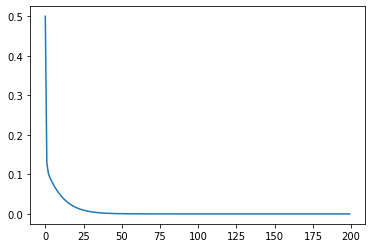

In [162]:
plt.plot(errs_bpc)

In [163]:
# Trained perfectly
bpcheck.get_output([0,1], 12, 5)

array([[0.50000155, 0.50000155],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.25000193, 0.25000193]])

In [146]:
fc = GraphNet(7)
fc.connect(0,1)
fc.connect_complete([1,2,3,4,5])
fc.connect(5,6)
#fc.activation(6, 'sigma')
fc.init_markov()

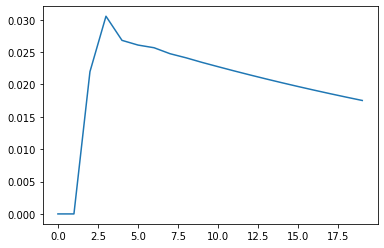

In [150]:
plt.plot(fc.get_output([1], 20, 20))

In [151]:
fc.backprop([[1]], [[1]], delay=10)

(array([[ 0.        , -0.02285141,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.04698958, -0.05082877, -0.04699833,
         -0.05913729,  0.        ],
        [ 0.        , -0.02796992,  0.        , -0.03240219, -0.02809855,
         -0.04159034,  0.        ],
        [ 0.        , -0.03067392, -0.03088159,  0.        , -0.03081258,
         -0.04663744,  0.        ],
        [ 0.        , -0.02969746, -0.02992878, -0.0346864 ,  0.        ,
         -0.04481153,  0.        ],
        [ 0.        , -0.03052507, -0.03075028, -0.03598602, -0.0306719 ,
          0.        , -0.17626287],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ]]), 0.9537496630970231)

In [152]:
fc.gradient_check([[1]], [[1]], delay=10, epsilon=0.00001)

Backprop-calculated gradient:
[[ 0.         -0.02285141  0.          0.          0.          0.
   0.        ]
 [ 0.          0.         -0.04698958 -0.05082877 -0.04699833 -0.05913729
   0.        ]
 [ 0.         -0.02796992  0.         -0.03240219 -0.02809855 -0.04159034
   0.        ]
 [ 0.         -0.03067392 -0.03088159  0.         -0.03081258 -0.04663744
   0.        ]
 [ 0.         -0.02969746 -0.02992878 -0.0346864   0.         -0.04481153
   0.        ]
 [ 0.         -0.03052507 -0.03075028 -0.03598602 -0.0306719   0.
  -0.17626287]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]]
Manually-calculated gradient:
[[ 0.         -0.02285141  0.          0.          0.          0.
   0.        ]
 [ 0.          0.         -0.04698987 -0.05082919 -0.04699863 -0.05913776
   0.        ]
 [ 0.         -0.02797004  0.         -0.0324023  -0.02809867 -0.04159059
   0.        ]
 [ 0.         -0.03067403 -0.03088172  0.         -0.0308127  -0.04663773
   0.  